In [18]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import glob
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
# import keras_metrics

## TODO:
* Implement a confusion matrix
* Implement grid search to find the right configuration
* Use F measure as we want recall of 1, no false negatives

In [3]:
fleisch = pd.read_excel('Archive_files/Archiv/Fleisch.xls').astype(float)
stoff =pd.read_excel('Archive_files/Archiv/Stoff.xls').astype(float)
leder = pd.read_excel('Archive_files/Archiv/Leder.xls').astype(float)
holz = pd.read_excel('Archive_files/Archiv/Holz.xls').astype(float)
haut = pd.read_excel('Archive_files/Archiv/Referenz-Haut_6-Klassen.xls').astype(float)
skin = pd.read_csv('Archive_files/Archiv/2016skin.csv', sep=';', decimal=',').astype(float)
skin.dropna(axis=0, inplace=True)
material = pd.read_csv('Archive_files/Archiv/2016material.csv', sep=';', decimal=',').astype(float)
material.dropna(axis=0, inplace=True)
material_fake = pd.read_csv('Archive_files/Archiv/2016material-fake.csv', sep=';', decimal=',').astype(float)
material_fake.dropna(axis=0, inplace=True)
# haut_2016 = pd.read_csv('Archive_files/Archiv/Referenz-Haut_6-Klassen.csv', sep=';', decimal=',').astype(float)
# haut_2016.dropna(axis=0, inplace=True)

print('================================================================')
print(' Data sets shapes')
print('Fleisch ', fleisch.shape)
print('Stoff ', stoff.shape)
print('Leder ', leder.shape)
print('Haut ', haut.shape)
# print('Haut 2016 ', haut_2016.shape)
print('Holz ', holz.shape)
print('Skin ', skin.shape)
print('Material ', material.shape)
print('Material Fake ', material_fake.shape)

 Data sets shapes
Fleisch  (121, 71)
Stoff  (121, 11)
Leder  (121, 30)
Haut  (121, 7)
Holz  (121, 63)
Skin  (1021, 1112)
Material  (1021, 336)
Material Fake  (1021, 33)


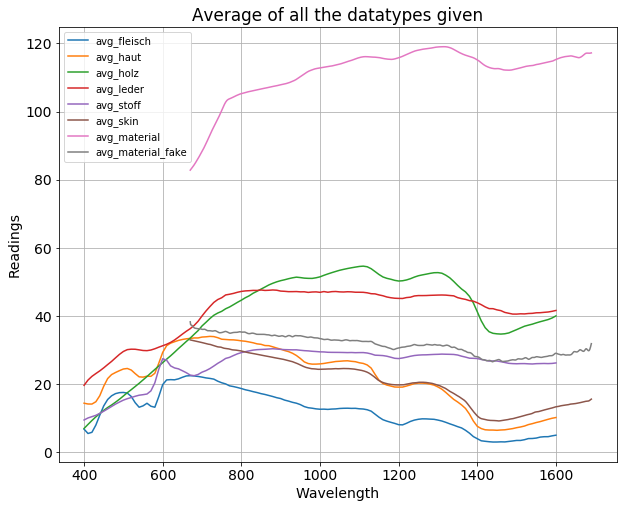

In [4]:
avg_fleisch = np.array(fleisch.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_leder = np.array(leder.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_holz = np.array(holz.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_stoff = np.array(stoff.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_haut = np.array(haut.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_skin = np.array(skin.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_material = np.array(material.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_material_fake = np.array(material_fake.iloc[:,1:].mean(axis = 1))[np.newaxis].T

wavelength = np.array(fleisch['nm'])[np.newaxis].T
wavelength_2016 = np.array(skin['nm'])[np.newaxis].T

# Plot the average values
plt.figure(figsize=[10,8])
plt.rcParams.update({'font.size': 14})

# Plot the different data 
plt.plot(wavelength,avg_fleisch,label='avg_fleisch')
plt.plot(wavelength,avg_haut,label='avg_haut')
plt.plot(wavelength,avg_holz,label='avg_holz')
plt.plot(wavelength,avg_leder,label='avg_leder')
plt.plot(wavelength,avg_stoff,label='avg_stoff')
plt.plot(wavelength_2016,avg_skin,label='avg_skin')
plt.plot(wavelength_2016,avg_material,label='avg_material')
plt.plot(wavelength_2016,avg_material_fake,label='avg_material_fake')

# Plot properties
plt.grid()
plt.title('Average of all the datatypes given')
plt.xlabel('Wavelength')
plt.ylabel('Readings')
plt.legend(loc='upper left',prop={'size': 10})

In [5]:
from sklearn.decomposition import PCA

def dataCleanup(data):

    gross_avg = np.array(data.iloc[:,1:].mean(axis = 1))

    # print('average of the combined dataset={}'.format(gross_avg.shape))

    mean_removed_data = data.subtract(gross_avg, axis = 0)
    
#     mean_removed_data.index

    pca = PCA(n_components=5)

    pca.fit(mean_removed_data)

    cleaned_data = pca.transform(mean_removed_data)    
    
    print('number of components selected to maintain = {}'.format(pca.n_components_))
    print('the variance ratio for each component = {}'.format(pca.explained_variance_ratio_))

    cleaned_data = pd.DataFrame(index = mean_removed_data.index, data = cleaned_data)
    return cleaned_data


In [6]:
print('=========================================================================')
print("Performing PCA on the dataset to use the features with more relevance")
print('=========================================================================')

print('------------- FLEISCH -------------')
fleisch_cleaned = dataCleanup(fleisch.set_index('nm'))
print('-------------   HAUT  -------------')
haut_cleaned = dataCleanup(haut.set_index('nm'))
print('-------------   SKIN  -------------')
skin_cleaned = dataCleanup(skin.set_index('nm'))
print('-----------   MATERIAL  -----------')
material_cleaned = dataCleanup(material.set_index('nm'))
print('---------   MATERIAL FAKE  --------')
material_fake_cleaned = dataCleanup(material_fake.set_index('nm'))
print('-------------   HOLZ  -------------')
holz_cleaned = dataCleanup(holz.set_index('nm'))
print('-------------  LEDER  -------------')
leder_cleaned = dataCleanup(leder.set_index('nm'))
print('-------------  STOFF  -------------')
stoff_cleaned = dataCleanup(stoff.set_index('nm'))


print('=========================================================================')
print("Creating the labels to train the network")
print('=========================================================================')
fleisch_labels = np.ones((len(fleisch_cleaned),1))
print("Fleisch Labels: ",fleisch_labels.shape)

haut_labels = np.ones((len(haut_cleaned),1))
print("Haut Labels: ",haut_labels.shape)

skin_labels = np.ones((len(skin_cleaned),1))
print("Skin Labels: ",skin_labels.shape)

material_labels = np.zeros((len(material_cleaned),1))
print("Material Labels: ",material_labels.shape)

material_fake_labels = np.zeros((len(material_fake_cleaned),1))
print("Material Fake Labels: ",material_fake_labels.shape)

holz_labels = np.zeros((len(holz_cleaned),1))
print("Holz Labels: ",holz_labels.shape)

leder_labels = np.zeros((len(leder_cleaned),1))
print("Leder Labels: ",leder_labels.shape)

stoff_labels = np.zeros((len(stoff_cleaned),1))
print("Stoff Labels: ", stoff_labels.shape)

print('=========================================================================')
print("Combining all the datasets and labels")
print('=========================================================================')
ultimate_dataset = np.vstack((fleisch_cleaned, holz_cleaned, leder_cleaned, haut_cleaned,\
                             stoff_cleaned, skin_cleaned, material_cleaned, material_fake_cleaned))
print("Dataset size: ", ultimate_dataset.shape)
ultimate_labels = np.vstack((fleisch_labels, holz_labels, leder_labels, haut_labels,\
                            stoff_labels, skin_labels, material_labels, material_fake_labels))
print("Dataset labels size: ", ultimate_labels.shape)

Performing PCA on the dataset to use the features with more relevance
------------- FLEISCH -------------
number of components selected to maintain = 5
the variance ratio for each component = [0.49438838 0.41809529 0.05047013 0.01283651 0.01124949]
-------------   HAUT  -------------
number of components selected to maintain = 5
the variance ratio for each component = [9.16839731e-01 4.61027036e-02 3.46245442e-02 2.03902143e-03
 3.94000293e-04]
-------------   SKIN  -------------
number of components selected to maintain = 5
the variance ratio for each component = [0.51215803 0.17534816 0.10841763 0.05867447 0.02920357]
-----------   MATERIAL  -----------
number of components selected to maintain = 5
the variance ratio for each component = [0.79352202 0.12337181 0.04645593 0.01976825 0.00792763]
---------   MATERIAL FAKE  --------
number of components selected to maintain = 5
the variance ratio for each component = [0.57449839 0.21529934 0.1165865  0.03039278 0.01444067]
------------- 

In [19]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [20]:
recall = as_keras_metric(tf.metrics.recall)

In [8]:
mlp = Sequential()
mlp.add(Dense(units = 5,input_dim = 5, init = 'uniform'))
mlp.add(Dense(units = 10, activation='relu'))
mlp.add(Dense(units = 6, activation='relu'))
mlp.add(Dense(units = 1, activation ='sigmoid'))

mlp.compile(loss='mean_absolute_error',
              optimizer= keras.optimizers.SGD(lr=0.12, momentum=0.1, nesterov=True),
              metrics=['accuracy'])

mlp.fit(ultimate_dataset, ultimate_labels, epochs = 15, batch_size = 201)

Epoch 1/15
3668/3668 [==============================] - 1s 185us/step - loss: 0.5000 - acc: 0.4836
Epoch 2/15
3668/3668 [==============================] - 0s 8us/step - loss: 0.4870 - acc: 0.4937
Epoch 3/15
3668/3668 [==============================] - 0s 14us/step - loss: 0.4708 - acc: 0.5044
Epoch 4/15
3668/3668 [==============================] - 0s 9us/step - loss: 0.4242 - acc: 0.5856
Epoch 5/15
3668/3668 [==============================] - 0s 12us/step - loss: 0.3511 - acc: 0.6557
Epoch 6/15
3668/3668 [==============================] - 0s 13us/step - loss: 0.3414 - acc: 0.6644
Epoch 7/15
3668/3668 [==============================] - 0s 9us/step - loss: 0.3195 - acc: 0.6933
Epoch 8/15
3668/3668 [==============================] - 0s 13us/step - loss: 0.3098 - acc: 0.6996
Epoch 9/15
3668/3668 [==============================] - 0s 13us/step - loss: 0.3055 - acc: 0.7017
Epoch 10/15
3668/3668 [==============================] - 0s 8us/step - loss: 0.3030 - acc: 0.7026
Epoch 11/15
3668/3668 

In [9]:
mlp = Sequential()
mlp.add(Dense(units = 5,input_dim = 5, init = 'uniform'))
mlp.add(Dense(units = 10, activation='relu'))
mlp.add(Dense(units = 6, activation='relu'))
mlp.add(Dense(units = 1, activation ='sigmoid'))

mlp.compile(loss='logcosh',
              optimizer= keras.optimizers.SGD(lr=0.12, momentum=0.1, nesterov=True),
              metrics=['accuracy'])
mlp.fit(ultimate_dataset, ultimate_labels, epochs = 15, batch_size = 201)

Epoch 1/15
3668/3668 [==============================] - 0s 57us/step - loss: 0.1664 - acc: 0.5548
Epoch 2/15
3668/3668 [==============================] - 0s 14us/step - loss: 0.1350 - acc: 0.6818
Epoch 3/15
3668/3668 [==============================] - 0s 12us/step - loss: 0.1239 - acc: 0.6974
Epoch 4/15
3668/3668 [==============================] - 0s 11us/step - loss: 0.1155 - acc: 0.7186
Epoch 5/15
3668/3668 [==============================] - 0s 10us/step - loss: 0.1145 - acc: 0.7225
Epoch 6/15
3668/3668 [==============================] - 0s 10us/step - loss: 0.1131 - acc: 0.7290
Epoch 7/15
3668/3668 [==============================] - 0s 13us/step - loss: 0.1175 - acc: 0.7208
Epoch 8/15
3668/3668 [==============================] - 0s 12us/step - loss: 0.1101 - acc: 0.7380
Epoch 9/15
3668/3668 [==============================] - 0s 11us/step - loss: 0.1090 - acc: 0.7426
Epoch 10/15
3668/3668 [==============================] - 0s 11us/step - loss: 0.1095 - acc: 0.7388
Epoch 11/15
3668/36

## Implementing Cross Validation

In [21]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(ultimate_dataset, ultimate_labels):
    # create model
    mlp = Sequential()
    mlp.add(Dense(units = 5,input_dim = 5, init = 'uniform'))
    mlp.add(Dense(units = 10, activation='relu'))
    mlp.add(Dense(units = 6, activation='relu'))
    mlp.add(Dense(units = 1, activation ='sigmoid'))

#     mlp.compile(loss='logcosh',
#               optimizer= keras.optimizers.SGD(lr=0.12, momentum=0.1, nesterov=True),
#               metrics=['accuracy'])
    mlp.compile(loss='logcosh',
              optimizer= 'adam',
              metrics=['accuracy', recall])
    mlp.fit(ultimate_dataset[train], ultimate_labels[train], epochs = 100, batch_size = 10)
    
    # evaluate the model
    scores = mlp.evaluate(ultimate_dataset[test], ultimate_labels[test], verbose=0)
    print('======================================================')
    print("%s: %.2f%%" % (mlp.metrics_names[1], scores[1]*100))
    print('======================================================')
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


Epoch 1/100
2934/2934 [==============================] - 1s 371us/step - loss: 0.0886 - acc: 0.6745 - recall: 0.9966
Epoch 2/100
2934/2934 [==============================] - 1s 185us/step - loss: 0.0742 - acc: 0.7757 - recall: 1.0000
Epoch 3/100
2934/2934 [==============================] - 0s 150us/step - loss: 0.0599 - acc: 0.8136 - recall: 1.0000
Epoch 4/100
2934/2934 [==============================] - 0s 146us/step - loss: 0.0519 - acc: 0.8596 - recall: 1.0000
Epoch 5/100
2934/2934 [==============================] - 0s 138us/step - loss: 0.0473 - acc: 0.8838 - recall: 1.0000
Epoch 6/100
2934/2934 [==============================] - 0s 144us/step - loss: 0.0450 - acc: 0.8862 - recall: 1.0000
Epoch 7/100
2934/2934 [==============================] - 1s 203us/step - loss: 0.0424 - acc: 0.8913 - recall: 1.0000
Epoch 8/100
2934/2934 [==============================] - 1s 206us/step - loss: 0.0405 - acc: 0.9012 - recall: 1.0000
Epoch 9/100
2934/2934 [==============================] - 0s 153u

2934/2934 [==============================] - 0s 151us/step - loss: 0.0123 - acc: 0.9734 - recall: 1.0000
Epoch 71/100
2934/2934 [==============================] - 0s 135us/step - loss: 0.0115 - acc: 0.9755 - recall: 1.0000
Epoch 72/100
2934/2934 [==============================] - 0s 136us/step - loss: 0.0109 - acc: 0.9741 - recall: 1.0000
Epoch 73/100
2934/2934 [==============================] - 0s 142us/step - loss: 0.0112 - acc: 0.9765 - recall: 1.0000
Epoch 74/100
2934/2934 [==============================] - 0s 138us/step - loss: 0.0113 - acc: 0.9751 - recall: 1.0000
Epoch 75/100
2934/2934 [==============================] - 0s 137us/step - loss: 0.0099 - acc: 0.9778 - recall: 1.0000
Epoch 76/100
2934/2934 [==============================] - 0s 141us/step - loss: 0.0102 - acc: 0.9778 - recall: 1.0000
Epoch 77/100
2934/2934 [==============================] - 0s 143us/step - loss: 0.0110 - acc: 0.9734 - recall: 1.0000
Epoch 78/100
2934/2934 [==============================] - 0s 137us/st

2934/2934 [==============================] - 0s 149us/step - loss: 0.0191 - acc: 0.9489 - recall: 1.0000
Epoch 39/100
2934/2934 [==============================] - 0s 150us/step - loss: 0.0192 - acc: 0.9485 - recall: 1.0000
Epoch 40/100
2934/2934 [==============================] - 0s 147us/step - loss: 0.0186 - acc: 0.9509 - recall: 1.0000
Epoch 41/100
2934/2934 [==============================] - 0s 146us/step - loss: 0.0184 - acc: 0.9513 - recall: 1.0000
Epoch 42/100
2934/2934 [==============================] - 0s 147us/step - loss: 0.0184 - acc: 0.9513 - recall: 1.0000
Epoch 43/100
2934/2934 [==============================] - 0s 148us/step - loss: 0.0179 - acc: 0.9516 - recall: 1.0000
Epoch 44/100
2934/2934 [==============================] - 0s 150us/step - loss: 0.0180 - acc: 0.9516 - recall: 1.0000
Epoch 45/100
2934/2934 [==============================] - 0s 148us/step - loss: 0.0183 - acc: 0.9502 - recall: 1.0000
Epoch 46/100
2934/2934 [==============================] - 0s 150us/st

2934/2934 [==============================] - 0s 149us/step - loss: 0.0455 - acc: 0.8783 - recall: 1.0000
Epoch 7/100
2934/2934 [==============================] - 0s 149us/step - loss: 0.0426 - acc: 0.8879 - recall: 1.0000
Epoch 8/100
2934/2934 [==============================] - 0s 149us/step - loss: 0.0392 - acc: 0.8960 - recall: 1.0000
Epoch 9/100
2934/2934 [==============================] - 0s 151us/step - loss: 0.0375 - acc: 0.9012 - recall: 1.0000
Epoch 10/100
2934/2934 [==============================] - 0s 143us/step - loss: 0.0368 - acc: 0.9012 - recall: 1.0000
Epoch 11/100
2934/2934 [==============================] - 0s 151us/step - loss: 0.0362 - acc: 0.9029 - recall: 1.0000
Epoch 12/100
2934/2934 [==============================] - 0s 150us/step - loss: 0.0337 - acc: 0.9093 - recall: 1.0000
Epoch 13/100
2934/2934 [==============================] - 0s 152us/step - loss: 0.0317 - acc: 0.9165 - recall: 1.0000
Epoch 14/100
2934/2934 [==============================] - 0s 155us/step 

2934/2934 [==============================] - 0s 159us/step - loss: 0.0095 - acc: 0.9775 - recall: 1.0000
Epoch 76/100
2934/2934 [==============================] - 0s 148us/step - loss: 0.0091 - acc: 0.9775 - recall: 1.0000
Epoch 77/100
2934/2934 [==============================] - 0s 150us/step - loss: 0.0090 - acc: 0.9796 - recall: 1.0000
Epoch 78/100
2934/2934 [==============================] - 0s 149us/step - loss: 0.0090 - acc: 0.9785 - recall: 1.0000
Epoch 79/100
2934/2934 [==============================] - 0s 147us/step - loss: 0.0086 - acc: 0.9806 - recall: 1.0000
Epoch 80/100
2934/2934 [==============================] - 0s 146us/step - loss: 0.0085 - acc: 0.9799 - recall: 1.0000
Epoch 81/100
2934/2934 [==============================] - 0s 150us/step - loss: 0.0082 - acc: 0.9799 - recall: 1.0000
Epoch 82/100
2934/2934 [==============================] - 0s 145us/step - loss: 0.0084 - acc: 0.9792 - recall: 1.0000
Epoch 83/100
2934/2934 [==============================] - 0s 152us/st

2935/2935 [==============================] - 0s 165us/step - loss: 0.0192 - acc: 0.9503 - recall: 1.0000
Epoch 44/100
2935/2935 [==============================] - 0s 151us/step - loss: 0.0184 - acc: 0.9530 - recall: 1.0000
Epoch 45/100
2935/2935 [==============================] - 0s 155us/step - loss: 0.0181 - acc: 0.9526 - recall: 1.0000
Epoch 46/100
2935/2935 [==============================] - 0s 155us/step - loss: 0.0182 - acc: 0.9499 - recall: 1.0000
Epoch 47/100
2935/2935 [==============================] - 0s 157us/step - loss: 0.0188 - acc: 0.9506 - recall: 1.0000
Epoch 48/100
2935/2935 [==============================] - 0s 154us/step - loss: 0.0180 - acc: 0.9523 - recall: 1.0000
Epoch 49/100
2935/2935 [==============================] - 0s 156us/step - loss: 0.0190 - acc: 0.9482 - recall: 1.0000
Epoch 50/100
2935/2935 [==============================] - 0s 163us/step - loss: 0.0181 - acc: 0.9530 - recall: 1.0000
Epoch 51/100
2935/2935 [==============================] - 0s 169us/st

2935/2935 [==============================] - 1s 176us/step - loss: 0.0359 - acc: 0.9063 - recall: 1.0000
Epoch 12/100
2935/2935 [==============================] - 1s 184us/step - loss: 0.0347 - acc: 0.9128 - recall: 1.0000
Epoch 13/100
2935/2935 [==============================] - 0s 159us/step - loss: 0.0336 - acc: 0.9175 - recall: 1.0000
Epoch 14/100
2935/2935 [==============================] - 0s 157us/step - loss: 0.0328 - acc: 0.9189 - recall: 1.0000
Epoch 15/100
2935/2935 [==============================] - 0s 163us/step - loss: 0.0321 - acc: 0.9193 - recall: 1.0000
Epoch 16/100
2935/2935 [==============================] - 0s 159us/step - loss: 0.0314 - acc: 0.9206 - recall: 1.0000
Epoch 17/100
2935/2935 [==============================] - 0s 166us/step - loss: 0.0306 - acc: 0.9244 - recall: 1.0000
Epoch 18/100
2935/2935 [==============================] - 1s 195us/step - loss: 0.0303 - acc: 0.9233 - recall: 1.0000
Epoch 19/100
2935/2935 [==============================] - 0s 161us/st

2935/2935 [==============================] - 0s 169us/step - loss: 0.0136 - acc: 0.9687 - recall: 1.0000
Epoch 81/100
2935/2935 [==============================] - 1s 180us/step - loss: 0.0137 - acc: 0.9693 - recall: 1.0000
Epoch 82/100
2935/2935 [==============================] - 1s 171us/step - loss: 0.0142 - acc: 0.9687 - recall: 1.0000
Epoch 83/100
2935/2935 [==============================] - 1s 181us/step - loss: 0.0141 - acc: 0.9687 - recall: 1.0000
Epoch 84/100
2935/2935 [==============================] - 0s 167us/step - loss: 0.0138 - acc: 0.9676 - recall: 1.0000
Epoch 85/100
2935/2935 [==============================] - 0s 166us/step - loss: 0.0152 - acc: 0.9625 - recall: 1.0000
Epoch 86/100
2935/2935 [==============================] - 1s 182us/step - loss: 0.0134 - acc: 0.9697 - recall: 1.0000
Epoch 87/100
2935/2935 [==============================] - 0s 166us/step - loss: 0.0144 - acc: 0.9656 - recall: 1.0000
Epoch 88/100
2935/2935 [==============================] - 1s 172us/st

In [22]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_measure_score = []
for train, test in kfold.split(ultimate_dataset, ultimate_labels):
    # create model
    mlp = Sequential()
    mlp.add(Dense(units = 5,input_dim = 5, init = 'uniform'))
    mlp.add(Dense(units = 10, activation='relu'))
    mlp.add(Dense(units = 6, activation='relu'))
    mlp.add(Dense(units = 1, activation ='sigmoid'))

#     mlp.compile(loss='logcosh',
#               optimizer= keras.optimizers.SGD(lr=0.12, momentum=0.1, nesterov=True),
#               metrics=['accuracy'])
    mlp.compile(loss='logcosh',
              optimizer= 'adam',
              metrics=['accuracy', recall])
    mlp.fit(ultimate_dataset[train], ultimate_labels[train], epochs = 50, batch_size = 10)
    
    # evaluate the model
    scores = mlp.evaluate(ultimate_dataset[test], ultimate_labels[test], verbose=0)
    print('======================================================')
    print("%s: %.2f%%" % (mlp.metrics_names[1], scores[1]))
    print("%s: %.2f%%" % (mlp.metrics_names[2], scores[2]))
    print('======================================================')
    accuracy_scores.append(scores[1])
    recall_scores.append(scores[2])
print("Average accuracy %.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print("Average recall %.2f%% (+/- %.2f%%)" % (np.mean(recall_scores), np.std(recall_scores)))    

Epoch 1/50
2934/2934 [==============================] - 1s 375us/step - loss: 0.0886 - acc: 0.6721 - recall: 0.9966
Epoch 2/50
2934/2934 [==============================] - 1s 171us/step - loss: 0.0737 - acc: 0.7635 - recall: 1.0000
Epoch 3/50
2934/2934 [==============================] - 1s 180us/step - loss: 0.0585 - acc: 0.8303 - recall: 1.0000
Epoch 4/50
2934/2934 [==============================] - 1s 184us/step - loss: 0.0490 - acc: 0.8947 - recall: 1.0000
Epoch 5/50
2934/2934 [==============================] - 1s 202us/step - loss: 0.0432 - acc: 0.9162 - recall: 1.0000
Epoch 6/50
2934/2934 [==============================] - 1s 187us/step - loss: 0.0392 - acc: 0.9209 - recall: 1.0000
Epoch 7/50
2934/2934 [==============================] - 1s 205us/step - loss: 0.0384 - acc: 0.9172 - recall: 1.0000
Epoch 8/50
2934/2934 [==============================] - 1s 180us/step - loss: 0.0343 - acc: 0.9264 - recall: 1.0000
Epoch 9/50
2934/2934 [==============================] - 1s 204us/step - 

2934/2934 [==============================] - 1s 195us/step - loss: 0.0294 - acc: 0.9233 - recall: 1.0000
Epoch 21/50
2934/2934 [==============================] - 1s 192us/step - loss: 0.0300 - acc: 0.9237 - recall: 1.0000
Epoch 22/50
2934/2934 [==============================] - 1s 200us/step - loss: 0.0274 - acc: 0.9288 - recall: 1.0000
Epoch 23/50
2934/2934 [==============================] - 1s 180us/step - loss: 0.0269 - acc: 0.9294 - recall: 1.0000
Epoch 24/50
2934/2934 [==============================] - 1s 178us/step - loss: 0.0276 - acc: 0.9274 - recall: 1.0000
Epoch 25/50
2934/2934 [==============================] - 1s 243us/step - loss: 0.0259 - acc: 0.9312 - recall: 1.0000
Epoch 26/50
2934/2934 [==============================] - 1s 235us/step - loss: 0.0254 - acc: 0.9342 - recall: 1.0000
Epoch 27/50
2934/2934 [==============================] - 0s 151us/step - loss: 0.0272 - acc: 0.9260 - recall: 1.0000
Epoch 28/50
2934/2934 [==============================] - 0s 141us/step - los

2934/2934 [==============================] - 0s 137us/step - loss: 0.0196 - acc: 0.9499 - recall: 1.0000
Epoch 40/50
2934/2934 [==============================] - 0s 141us/step - loss: 0.0197 - acc: 0.9492 - recall: 1.0000
Epoch 41/50
2934/2934 [==============================] - 0s 133us/step - loss: 0.0197 - acc: 0.9492 - recall: 1.0000
Epoch 42/50
2934/2934 [==============================] - 0s 139us/step - loss: 0.0193 - acc: 0.9496 - recall: 1.0000
Epoch 43/50
2934/2934 [==============================] - 0s 137us/step - loss: 0.0190 - acc: 0.9513 - recall: 1.0000
Epoch 44/50
2934/2934 [==============================] - 1s 178us/step - loss: 0.0188 - acc: 0.9516 - recall: 1.0000
Epoch 45/50
2934/2934 [==============================] - 0s 150us/step - loss: 0.0183 - acc: 0.9519 - recall: 1.0000
Epoch 46/50
2934/2934 [==============================] - 1s 195us/step - loss: 0.0181 - acc: 0.9526 - recall: 1.0000
Epoch 47/50
2934/2934 [==============================] - 0s 141us/step - los

Epoch 7/50
2935/2935 [==============================] - 1s 201us/step - loss: 0.0407 - acc: 0.8862 - recall: 1.0000
Epoch 8/50
2935/2935 [==============================] - 1s 196us/step - loss: 0.0367 - acc: 0.9141 - recall: 1.0000
Epoch 9/50
2935/2935 [==============================] - 1s 190us/step - loss: 0.0338 - acc: 0.9254 - recall: 1.0000
Epoch 10/50
2935/2935 [==============================] - 1s 207us/step - loss: 0.0338 - acc: 0.9182 - recall: 1.0000
Epoch 11/50
2935/2935 [==============================] - 1s 232us/step - loss: 0.0310 - acc: 0.9227 - recall: 1.0000
Epoch 12/50
2935/2935 [==============================] - 1s 233us/step - loss: 0.0306 - acc: 0.9274 - recall: 1.0000
Epoch 13/50
2935/2935 [==============================] - 1s 243us/step - loss: 0.0288 - acc: 0.9322 - recall: 1.0000
Epoch 14/50
2935/2935 [==============================] - 1s 224us/step - loss: 0.0276 - acc: 0.9298 - recall: 1.0000
Epoch 15/50
2935/2935 [==============================] - 1s 226us/s

In [23]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(ultimate_dataset, ultimate_labels, test_size = 0.20)  

In [ ]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='poly', degree=8)  
svclassifier.fit(X_train, y_train)  

In [ ]:
y_pred = svclassifier.predict(X_test)  

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  